# Proyecto final: Clasificación de URLs maliciosas mediante redes neuronales

In [1]:
# librerias necesarias

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

Antes de comenzar con el preprocesamiento de datos se realizó una corrección al dataset utilizado, dado que el dataset utilizado es en realidad una recopilación de distintos dataset, en Kaggle un usuario encontró un error donde las etiquetas de uno de los dataset originales (*phishstorm*) fueron invertidas, por lo que se descargó el dataset original y se realizó la corrección al dataset, el trabajo realizado se encuentra en la carpeta *correccion_dataset*.

De igual manera al realizar esta corrección se encontró un pequeño grupo de urls donde existía un error de codificación en el texto, por lo que se removieron manualmente.

El archivo resultante que se utiliza es *malicious_phish_updated.csv*

In [3]:
urls = pd.read_csv('malicious_phish_updated.csv')
urls

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651092,xbox360.ign.com/objects/850/850402.html,benign
651093,games.teamxbox.com/xbox-360/1860/Dead-Space/,benign
651094,www.gamespot.com/xbox360/action/deadspace/,benign
651095,en.wikipedia.org/wiki/Dead_Space_(video_game),benign


type
benign        428208
defacement     96457
phishing       93912
malware        32520
Name: count, dtype: int64


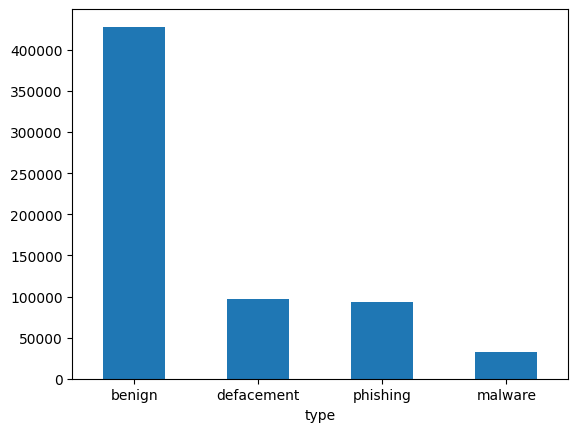

In [4]:
label_counts = urls['type'].value_counts()

print(label_counts)

label_counts.plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.show()

# Preprocesamiento de datos

In [5]:
from urllib.parse import urlparse

## Balanceo de datos

Al tener datos significativamente desbalanceados, el reducir a la mitad la clase predominante (benign) ayuda en gran proporción al aprendizaje de la red.

type
benign        171283
defacement     96457
phishing       93912
malware        32520
Name: count, dtype: int64


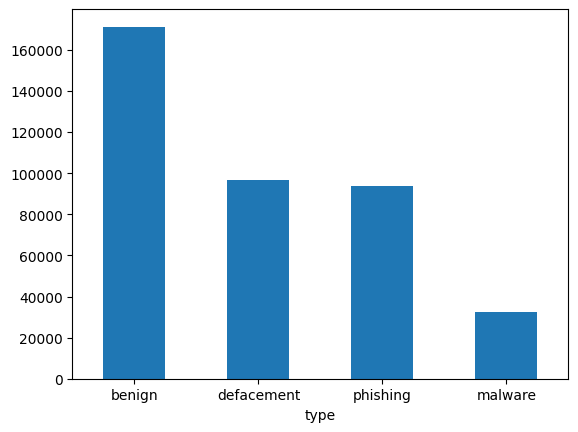

In [6]:
benign_rows = urls[urls['type'] == 'benign']
rows_to_drop = benign_rows.sample(frac=0.6)
urls = urls.drop(rows_to_drop.index)
urls.reset_index(drop=True)
urls = urls.reset_index(drop=True)

label_counts = urls['type'].value_counts()
print(label_counts)
label_counts.plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.show()

## Tamaño de URL

In [7]:
urls['length'] = urls['url'].apply(len)

## Densidad de vocales presentes en la URL

In [8]:
def calculate_vowel_density(url):
    vowels = 'aeiou'
    vowel_count = sum(1 for char in url if char.lower() in vowels)
    return vowel_count / len(url)

In [9]:
urls['vowel_density'] = urls['url'].apply(calculate_vowel_density)

## Densidad de consonantes presentes en la URL

In [10]:
def calculate_consonant_density(text):
    consonants = 'bcdfghjklmnpqrstvwxyz'
    consonant_count = sum(1 for char in text if char.lower() in consonants)
    return consonant_count / len(text)

In [11]:
urls['consonant_density'] = urls['url'].apply(calculate_consonant_density)

## Densidad de digitos presentes en la URL

In [12]:
def calculate_digit_density(url):
    digit_count = sum(1 for char in url if char.isdigit())  
    return digit_count / len(url)

In [13]:
urls['digit_density'] = urls['url'].apply(calculate_digit_density)

## Densidad de símbolos presentes en la URL

In [14]:
def calculate_symbol_density(url):
    symbol_count = sum(1 for char in url if not char.isalnum())
    return symbol_count / len(url)

In [15]:
urls['symbol_density'] = urls['url'].apply(calculate_symbol_density)

## Cantidad de vocales seguidas de una consonante

In [16]:
def vowel_consonant_density(url):
    vowels = 'aeiou'
    consonants = 'bcdfghjklmnpqrstvwxyz'
    pair_count = sum(1 for i in range(len(url) - 1) if url[i].lower() in vowels and url[i+1].lower() in consonants)
    return pair_count / len(url)

In [17]:
urls['vowel_consonant_pairs_density'] = urls['url'].apply(vowel_consonant_density)

## Cantidad de consonantes seguidas de vocales

In [18]:
def consonant_vowel_pairs_density(url):
    vowels = 'aeiou'
    consonants = 'bcdfghjklmnpqrstvwxyz'
    pair_count = sum(1 for i in range(len(url) - 1) if url[i].lower() in consonants and url[i+1].lower() in vowels)
    return pair_count / len(url)

In [19]:
urls['consonant_vowel_pairs_density'] = urls['url'].apply(consonant_vowel_pairs_density)

## Cantidad de vocales seguidas de vocales

In [20]:
def vowel_vowel_pairs_density(url):
    vowels = 'aeiou'
    pair_count = sum(1 for i in range(len(url) - 1) if url[i].lower() in vowels and url[i+1].lower() in vowels)
    return pair_count / len(url)

In [21]:
urls['vowel_vowel_pairs_density'] = urls['url'].apply(vowel_vowel_pairs_density)

## Cantidad de consonantes seguidas de consonantes

In [22]:
def consonant_consonant_pairs_density(url):
    consonants = 'bcdfghjklmnpqrstvwxyz'
    pair_count = sum(1 for i in range(len(url) - 1) if url[i].lower() in consonants and url[i+1].lower() in consonants)
    return pair_count / len(url)

In [23]:
urls['consonant_consonant_pairs_density'] = urls['url'].apply(consonant_consonant_pairs_density)

## Cantidad de dígitos seguidos de digitos

In [24]:
def digit_digit_pairs_density(url):
    pair_count = sum(1 for i in range(len(url) - 1) if url[i].isdigit() and url[i+1].isdigit())
    return pair_count / len(url) if url else 0

In [25]:
urls['digit_digit_pairs_density'] = urls['url'].apply(digit_digit_pairs_density)

## Tiene www

In [26]:
def has_www(url):
    return True if 'www' in url else False

In [27]:
urls['has_www'] = urls['url'].apply(has_www)

## Cantidad de mayúsculas

In [28]:
def capital_letter_density(url):
    capital_count = sum(1 for char in url if char.isupper())
    return capital_count / len(url) if url else 0

In [29]:
urls['capital_letter_density'] = urls['url'].apply(capital_letter_density)

## Tamaño del path

In [30]:
def count_subdirectories(url):
    return urlparse(url).path.count('/')


In [31]:
urls['subdirectories_count'] = urls['url'].apply(count_subdirectories)

## Número de consultas realizadas

In [32]:
def count_queries(url):
    return urlparse(url).query.count('=')

In [33]:
urls['query_count'] = urls['url'].apply(count_queries)

## Resultado de extracción de características

In [34]:
urls

,url,type,length,vowel_density,consonant_density,digit_density,symbol_density,vowel_consonant_pairs_density,consonant_vowel_pairs_density,vowel_vowel_pairs_density,consonant_consonant_pairs_density,digit_digit_pairs_density,has_www,capital_letter_density,subdirectories_count,query_count
0,br-icloud.com.br,phishing,16,0.250000,0.562500,0.000000,0.187500,0.187500,0.125000,0.062500,0.187500,0.000000,False,0.000000,0,0
1,bopsecrets.org/rexroth/cr/1.htm,benign,31,0.193548,0.612903,0.032258,0.161290,0.193548,0.161290,0.000000,0.290323,0.000000,False,0.000000,3,0
2,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0.250000,0.465909,0.079545,0.204545,0.181818,0.181818,0.022727,0.170455,0.034091,True,0.000000,1,4
3,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0.157447,0.689362,0.093617,0.059574,0.119149,0.102128,0.021277,0.472340,0.012766,False,0.268085,1,3
4,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,118,0.322034,0.466102,0.008475,0.203390,0.186441,0.186441,0.084746,0.144068,0.000000,False,0.000000,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394167,www.gamefaqs.com/computer/doswin/data/926310.html,benign,49,0.224490,0.510204,0.122449,0.142857,0.204082,0.224490,0.000000,0.163265,0.102041,True,0.000000,4,0
394168,xbox360.gamespy.com/xbox-360/condemned-2-blood...,benign,51,0.215686,0.490196,0.137255,0.156863,0.196078,0.196078,0.019608,0.176471,0.078431,False,0.000000,3,0
394169,games.teamxbox.com/xbox-360/1737/Condemned-2-B...,benign,55,0.236364,0.454545,0.145455,0.163636,0.200000,0.200000,0.036364,0.145455,0.090909,False,0.036364,4,0
394170,wii.gamespy.com/wii/cursed-mountain/,benign,36,0.361111,0.472222,0.000000,0.166667,0.194444,0.250000,0.111111,0.111111,0.000000,False,0.000000,3,0


# Creación de conjuntos de entrenamiento y prueba

In [35]:
scaler = MinMaxScaler()
x = pd.DataFrame (scaler.fit_transform(urls.drop(columns=['url', 'type'])))
x.columns = urls.columns[2:]
x = pd.concat([urls['url'],x], axis=1)
x

,url,length,vowel_density,consonant_density,digit_density,symbol_density,vowel_consonant_pairs_density,consonant_vowel_pairs_density,vowel_vowel_pairs_density,consonant_consonant_pairs_density,digit_digit_pairs_density,has_www,capital_letter_density,subdirectories_count,query_count
0,br-icloud.com.br,0.005069,0.375000,0.602679,0.000000,0.315149,0.412500,0.267857,0.137500,0.234375,0.000000,0.0,0.000000,0.000000,0.000000
1,bopsecrets.org/rexroth/cr/1.htm,0.011982,0.290323,0.656682,0.040860,0.268396,0.425806,0.345622,0.000000,0.362903,0.000000,0.0,0.000000,0.076923,0.000000
2,http://www.garage-pirenne.be/index.php?option=...,0.038249,0.375000,0.499188,0.100758,0.345555,0.400000,0.389610,0.050000,0.213068,0.045375,1.0,0.000000,0.025641,0.078431
3,http://adventure-nicaragua.net/index.php?optio...,0.105991,0.236170,0.738602,0.118582,0.086956,0.262128,0.218845,0.046809,0.590426,0.016991,0.0,0.286574,0.025641,0.058824
4,http://buzzfil.net/m/show-art/ils-etaient-loin...,0.052074,0.483051,0.499395,0.010734,0.343493,0.410169,0.399516,0.186441,0.180085,0.000000,0.0,0.000000,0.076923,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394167,www.gamefaqs.com/computer/doswin/data/926310.html,0.020276,0.336735,0.546647,0.155102,0.235515,0.448980,0.481050,0.000000,0.204082,0.135815,1.0,0.000000,0.102564,0.000000
394168,xbox360.gamespy.com/xbox-360/condemned-2-blood...,0.021198,0.323529,0.525210,0.173856,0.260499,0.431373,0.420168,0.043137,0.220588,0.104391,0.0,0.000000,0.076923,0.000000
394169,games.teamxbox.com/xbox-360/1737/Condemned-2-B...,0.023041,0.354545,0.487013,0.184242,0.272581,0.440000,0.428571,0.080000,0.181818,0.120999,0.0,0.038871,0.102564,0.000000
394170,wii.gamespy.com/wii/cursed-mountain/,0.014286,0.541667,0.505952,0.000000,0.277987,0.427778,0.535714,0.244444,0.138889,0.000000,0.0,0.000000,0.076923,0.000000


In [36]:
y = urls[['type']].copy()

y

,type
0,phishing
1,benign
2,defacement
3,defacement
4,benign
...,...
394167,benign
394168,benign
394169,benign
394170,benign


In [37]:
category_mapping = {"benign": 1, "defacement": 2, "phishing": 3, "malware": 4}
y['type'] = y['type'].map(category_mapping)
#y = pd.concat([urls['url'],y], axis=1)
y

,type
0,3
1,1
2,2
3,2
4,1
...,...
394167,1
394168,1
394169,1
394170,1


In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, shuffle=True, random_state=None)

In [39]:
y_train = OneHotEncoder().fit_transform(y_train).toarray()
y_test = OneHotEncoder().fit_transform(y_test).toarray()

y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [40]:
x_train_tensor = torch.tensor(x_train.iloc[:, 1:].values, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test.iloc[:, 1:].values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [41]:
x_train_tensor = x_train_tensor.to(device)
x_test_tensor = x_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [42]:
x_train_tensor.shape, y_train_tensor.shape, y_test_tensor.shape, y_test_tensor.shape

(torch.Size([275920, 14]),
 torch.Size([275920, 4]),
 torch.Size([118252, 4]),
 torch.Size([118252, 4]))

# Red neuronal

Se define la clase Nultilayer

In [47]:
class Multilayer(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(x_train_tensor.shape[1],80)
        self.hidden2 = nn.Linear(80,52)
        self.hidden3 = nn.Linear(52,52)
        self.output = nn.Linear(52,4)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.loss = nn.CrossEntropyLoss()
        self.historial = []
        
    def forward(self,X):
        X = self.hidden1(X)
        X = self.relu(X)
        X = self.hidden2(X)
        X = self.relu(X)
        X = self.hidden3(X)
        X = self.relu(X)
        X = self.output(X)
        X = self.softmax(X)
        return X
    
    def track_progress(self, error):
        self.historial.append(error.item())
    
    def back_propagate(self,X,Y):
        prediccion = self.forward(X)
        error = self.loss(prediccion,Y)
        self.zero_grad()
        error.backward()
        
    def train(self,train_X,train_Y,optimizer,epochs=100,verbose=False):
        for i in range(epochs):
            self.back_propagate(train_X,train_Y)
            optimizer.step()
            prediccion = self.forward(train_X)
            error = self.loss(prediccion,train_Y)
            self.track_progress(error)
            if verbose:
                print(f"Epoch [{i}], Error: {error.item()}")
    
    def confusion(self,test_X,test_Y):
        prediccion = self.forward(test_X)
        matriz = confusion_matrix(np.argmax(test_Y.cpu().detach().numpy(), axis=1), np.argmax(prediccion.cpu().detach().numpy(), axis=1))
        return matriz

## Entrenamiento de la red neuronal

In [48]:
from torch.optim import SGD
from torch.optim import Adam
from torch.optim import Adagrad

network = Multilayer().to(device)
optimizer = Adam(network.parameters(), lr=0.01)

In [49]:
torch.cuda.empty_cache() if torch.cuda.is_available() else None

In [50]:
# entrenamiento
network.train(x_train_tensor,y_train_tensor,optimizer,epochs=2000,verbose=True)

Epoch [0], Error: 1.3904814720153809
Epoch [1], Error: 1.3809057474136353
Epoch [2], Error: 1.366191029548645
Epoch [3], Error: 1.345727562904358
Epoch [4], Error: 1.3174575567245483
Epoch [5], Error: 1.290312647819519
Epoch [6], Error: 1.278833270072937
Epoch [7], Error: 1.2698488235473633
Epoch [8], Error: 1.2417380809783936
Epoch [9], Error: 1.2212786674499512
Epoch [10], Error: 1.2180631160736084
Epoch [11], Error: 1.1936218738555908
Epoch [12], Error: 1.183527946472168
Epoch [13], Error: 1.181680679321289
Epoch [14], Error: 1.1772407293319702
Epoch [15], Error: 1.1734014749526978
Epoch [16], Error: 1.1717264652252197
Epoch [17], Error: 1.1710028648376465
Epoch [18], Error: 1.170698881149292
Epoch [19], Error: 1.170556664466858
Epoch [20], Error: 1.170488715171814
Epoch [21], Error: 1.170453667640686
Epoch [22], Error: 1.1704270839691162
Epoch [23], Error: 1.170395851135254
Epoch [24], Error: 1.1703498363494873
Epoch [25], Error: 1.1702733039855957
Epoch [26], Error: 1.170135736465

[[46124   231  4938    92]
 [ 4097 19776  4817   247]
 [ 5615  1245 21131   183]
 [ 1535   447  1482  6292]]


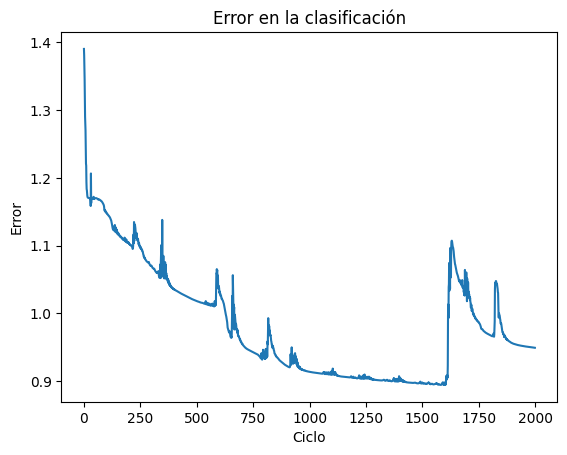

In [51]:
confusion = network.confusion(x_test_tensor,y_test_tensor)

print(confusion)

plt.plot(network.historial)
plt.title("Error en la clasificación")
plt.xlabel("Ciclo")
plt.ylabel("Error")
plt.show()

In [52]:
predictions = network(x_test_tensor).detach().cpu().numpy()
predictions = np.round(predictions).astype(int)
accuracy = accuracy_score(y_test, predictions)
print(f'Precision: {accuracy * 100}%')

Precision: 78.91536718195042%


## Visualización

In [328]:
classes = ['benign', 'defacement', 'phishing', 'malware']
url_slider = widgets.SelectionSlider(options=x_test['url'].values, description='URLs:')
button = widgets.Button(description='Predict')
output = widgets.Output()
def on_button_clicked(b):
    url = url_slider.value
    url
    url_data = [len(url), calculate_vowel_density(url), calculate_consonant_density(url), 
                calculate_digit_density(url), calculate_symbol_density(url),
                vowel_consonant_density(url), consonant_vowel_pairs_density(url),
                vowel_vowel_pairs_density(url), consonant_consonant_pairs_density(url),
                digit_digit_pairs_density(url), has_www(url), capital_letter_density(url),
                count_subdirectories(url), count_queries(url)]
    url_data_df = pd.DataFrame([url_data], columns=x.columns[1:])
    url_data = scaler.transform(url_data_df)
    url_data = torch.tensor(url_data, dtype=torch.float32)
    url_data = url_data.to(device)
    model_output = network(url_data)
    _, predicted = torch.max(model_output, 1)
    
    predicted_text = classes[predicted.item()]
    url_label_index = np.where(x_test['url'] == url)[0][0]
    label_text = classes[y_test[url_label_index].argmax()]
    
    with output:
        clear_output()
        print('Predicted: ', predicted_text)
        print('Label: ', label_text)
        
button.on_click(on_button_clicked)
display(url_slider, button, output)


SelectionSlider(description='URLs:', options=('persephone.cps.unizar.es/~spd/gzip/', 'forum.nhacvietplus.com.v…

Button(description='Predict', style=ButtonStyle())

Output()

# Notas

- El desbalance de los datos es muy importante, reducir la clase predominante (benign) a la mitad representa resultados significativamente mejores, pues el no hacerlo no permite a la red aprender

- Adam parece funcionar mejor que SGD

## Mejores resultados hasta ahora:

1. 50% benign, 3 capas (50,25,25), reLU, Adam, lr=0.01, 2000 epochs - Precision: 86.64739355291461%